In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("letter-recognition.data", header=None)

In [3]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
0     20000 non-null object
1     20000 non-null int64
2     20000 non-null int64
3     20000 non-null int64
4     20000 non-null int64
5     20000 non-null int64
6     20000 non-null int64
7     20000 non-null int64
8     20000 non-null int64
9     20000 non-null int64
10    20000 non-null int64
11    20000 non-null int64
12    20000 non-null int64
13    20000 non-null int64
14    20000 non-null int64
15    20000 non-null int64
16    20000 non-null int64
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [5]:
dataset[0].value_counts()

U    813
D    805
P    803
T    796
M    792
A    789
X    787
Y    786
N    783
Q    783
F    775
G    773
E    768
B    766
V    764
L    761
R    758
I    755
O    753
W    752
S    748
J    747
K    739
C    736
Z    734
H    734
Name: 0, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92a5d712b0>,
      dtype=object)

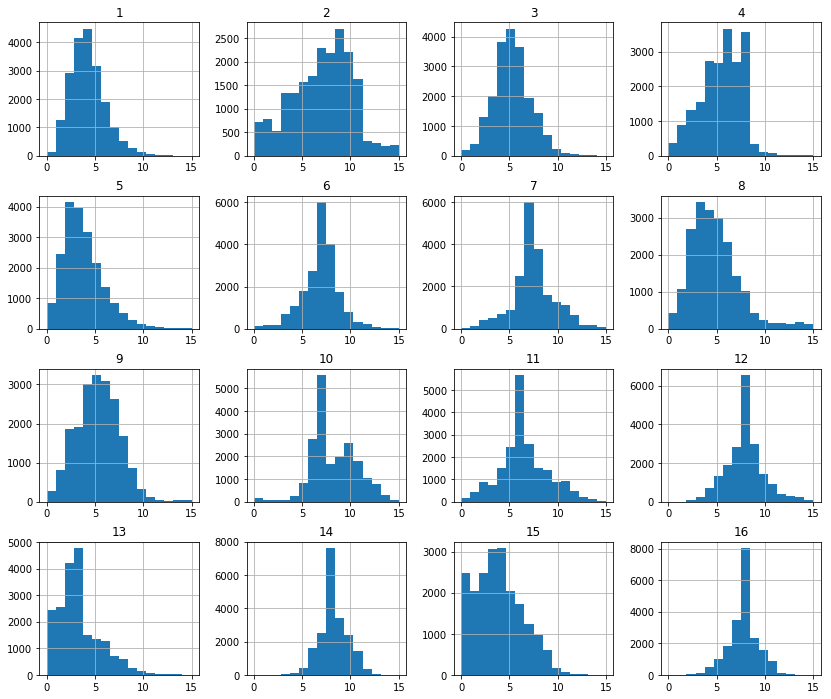

In [6]:
dataset.hist(bins=16, figsize=(14, 12))

In [7]:
X_data = dataset.iloc[:, 1:].values
y_data = dataset.iloc[:, 0].values

In [8]:
from sklearn.preprocessing import LabelBinarizer

l_binarizer = LabelBinarizer()
y_data = l_binarizer.fit_transform(y_data)

In [9]:
m, n = X_data.shape

In [10]:
n_inputs = n
n_hidden1 = 400
n_hidden2 = 165
n_outputs = 26 # A..Z

In [11]:
test_ratio = 0.2
test_size = int(m*test_ratio)
train_size = m - test_size

X_train = X_data[:-test_size]
X_test = X_data[-test_size:]
y_train = y_data[:-test_size]
y_test = y_data[-test_size:]

In [12]:
import tensorflow as tf

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.int32, shape=(None, n_outputs))

training = tf.placeholder_with_default(False, shape=())

In [13]:
from functools import partial

batch_momentum = 0.9
batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_momentum)

hidden1 = tf.layers.dense(X, n_hidden1)
bn1 = batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2)
bn2 = batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs)
logits = batch_norm_layer(logits_before_bn)

In [14]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.argmax(y, axis=1), logits=logits)
loss = tf.reduce_mean(xentropy)

In [15]:
learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [16]:
correct = tf.nn.in_top_k(logits, tf.argmax(y, axis=1), 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()

In [24]:
n_epochs = 45
batch_size = 120
n_batches = int(np.ceil(m/batch_size))

In [19]:
def fetch_batch(epoch, batch_index, batch_size):
    indices = np.random.randint(train_size, size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

In [25]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
                sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
                
            train_acc_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            test_acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
            test_loss_val = loss.eval(feed_dict={X: X_test, y: y_test})
            
            print("Epoch:", epoch, "Train Acc: {:.3f}".format(100*train_acc_val), 
                                   "Test Acc: {:.3f}".format(100*test_acc_val),
                                   "Test Loss: {:.3f}".format(100*test_loss_val))

Epoch: 0 Train Acc: 71.667 Test Acc: 67.725 Test Loss: 156.973
Epoch: 1 Train Acc: 75.000 Test Acc: 74.500 Test Loss: 127.534
Epoch: 2 Train Acc: 80.833 Test Acc: 77.300 Test Loss: 109.695
Epoch: 3 Train Acc: 80.833 Test Acc: 80.000 Test Loss: 96.990
Epoch: 4 Train Acc: 92.500 Test Acc: 81.600 Test Loss: 89.429
Epoch: 5 Train Acc: 87.500 Test Acc: 84.500 Test Loss: 79.611
Epoch: 6 Train Acc: 90.000 Test Acc: 85.175 Test Loss: 74.482
Epoch: 7 Train Acc: 92.500 Test Acc: 84.750 Test Loss: 70.488
Epoch: 8 Train Acc: 95.000 Test Acc: 86.050 Test Loss: 64.499
Epoch: 9 Train Acc: 91.667 Test Acc: 86.150 Test Loss: 63.040
Epoch: 10 Train Acc: 95.833 Test Acc: 87.525 Test Loss: 57.930
Epoch: 11 Train Acc: 89.167 Test Acc: 87.525 Test Loss: 59.123
Epoch: 12 Train Acc: 95.833 Test Acc: 89.000 Test Loss: 52.312
Epoch: 13 Train Acc: 94.167 Test Acc: 90.100 Test Loss: 48.033
Epoch: 14 Train Acc: 91.667 Test Acc: 90.200 Test Loss: 48.201
Epoch: 15 Train Acc: 96.667 Test Acc: 90.000 Test Loss: 46.070